# ECSE 415 - Introduction To Computer Vision
## Tutorial 9: Stereo Vision

In [ ]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44

In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/ECSE 415 Tutorials/Tutorial_9/'
print(path)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ECSE 415 Tutorials/Tutorial_9/


### Epipolar Geometry
In stereo vision, epipolar geometry describes the relationship between two views of the same 3D scene captured from different cameras or positions. The key elements of this geometry include:

1.	**Epipolar lines**: For a point in one image, the corresponding point in the other image must lie on a specific line (epipolar line).

2.	**Fundamental Matrix (F)**: Encodes the intrinsic relationship between corresponding points in two images.

3.	**Epipolar constraint**:  \textbf{x}{\prime} F \textbf{x} = 0 , where \textbf{x} and \textbf{x}{\prime} are homogeneous coordinates of corresponding points in the two images.

In [2]:
# drawlines visualizes epipolar lines, helping to debug or analyze stereo image pair matching.
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines on a pair of stereo images.

    Args:
        img1 (ndarray): The first grayscale image.
        img2 (ndarray): The second grayscale image.
        lines (ndarray): Epilines corresponding to points in the first image.
        pts1 (list): Points in the first image.
        pts2 (list): Corresponding points in the second image.

    Returns:
        Tuple[ndarray, ndarray]: The modified versions of img1 and img2 with drawn epilines and points.
    """
    # Get image dimensions (height and width).
    row, col = img1.shape

    # Convert grayscale images to BGR (for colored annotations).
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Iterate over each epiline and corresponding points
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # Generate a random color for each line
        color = tuple(np.random.randint(0, 255, 3).tolist())

        # Calculate the endpoints of the epiline for drawing (line equation: ax + by + c = 0)
        x0, y0 = map(int, [0, -r[2] / r[1]])  # Start point at x=0
        x1, y1 = map(int, [col, -(r[2] + r[0] * col) / r[1]])  # End point at x=col

        # Draw the epiline on the first image
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        # Draw the corresponding point on the first image
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        # Draw the corresponding point on the second image
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)

    return img1, img2

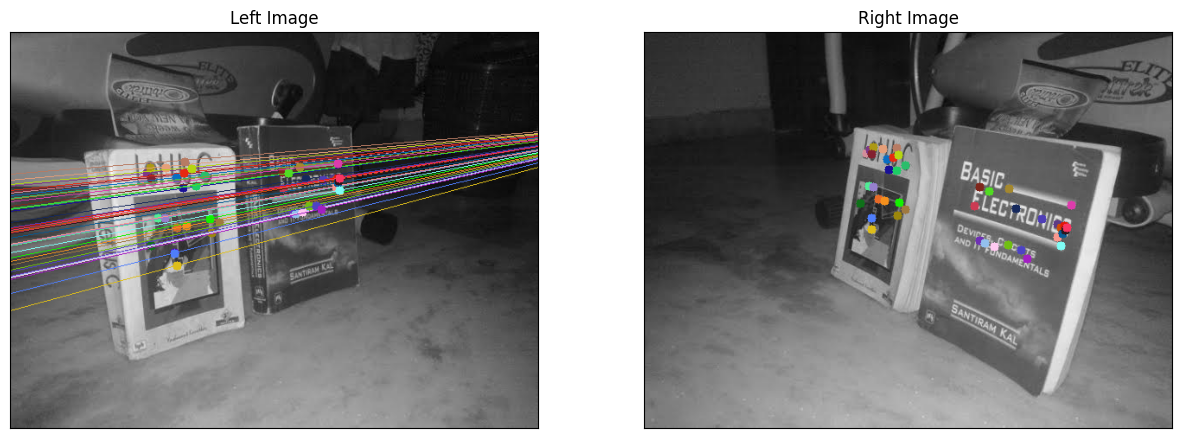

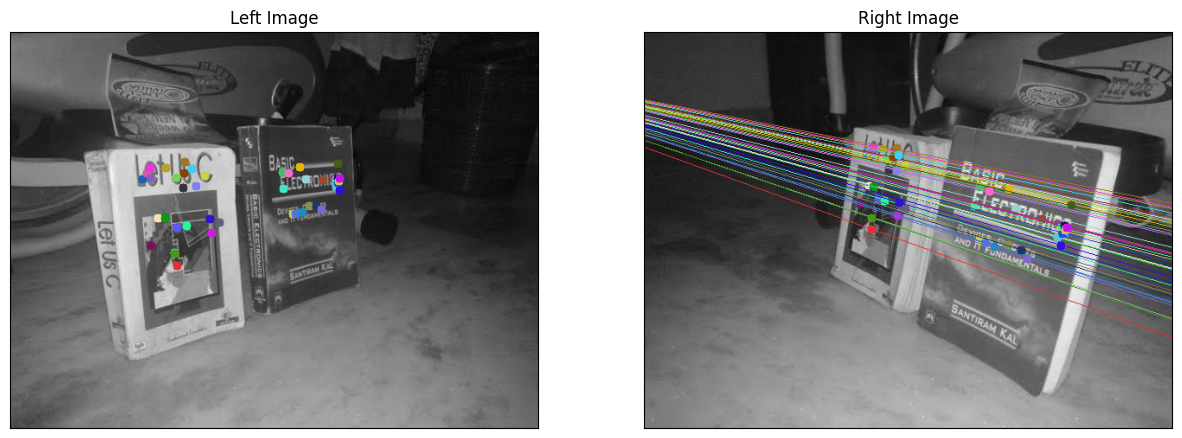

In [6]:
imgL = cv2.imread(path + "left.jpg", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(path + "right.jpg", cv2.IMREAD_GRAYSCALE)

# Detect and match features
sift = cv2.xfeatures2d.SIFT_create()  # Create a SIFT detector
kpL, desL = sift.detectAndCompute(imgL, None)  # Detect keypoints and compute descriptors
kpR, desR = sift.detectAndCompute(imgR, None)

bfMatcher = cv2.BFMatcher(cv2.NORM_L2)  # Create a Brute-Force matcher
matches = bfMatcher.knnMatch(desL, desR, k=2)  # Find the two best matches for each descriptor

# Filter matches using ratio test
good = []  # List to store good matches
ptsL = []  # List to store matched points from the left image
ptsR = []  # List to store matched points from the right image
# Lowe’s ratio test filters out ambiguous matches by comparing the distance ratio of the best and second-best matches.
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:  # Lowe's ratio test
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# Estimate the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)  # Robust estimation using LMEDS
ptsL = ptsL[mask.ravel() == 1]  # Use only inlier points
ptsR = ptsR[mask.ravel() == 1]

linesL = cv2.computeCorrespondEpilines(ptsR, 2, F).reshape(-1, 3)
linesR = cv2.computeCorrespondEpilines(ptsL, 1, F).reshape(-1, 3)

# Visualization
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)  # Draw epilines for Left->Right
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)  # Draw epilines for Right->Left

# Display annotated images
plt.figure(figsize=(15, 15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()
plt.show()

**Summarization**

In essence, epipolar geometry ensures that for every point in one image, its corresponding point in the other must lie on a predictable line, significantly simplifying 3D scene analysis.

Thus, the epipolar geometry is widely used for reducing the search space for matching points in stereo images and tasks like stereo depth estimation, 3D reconstruction, and camera calibration.

### Disparity Map

The disparity map represents the **difference in pixel locations** of corresponding points between the left and right images, which is key for depth estimation in 3D reconstruction.

The output is the disparity map, where brighter values represent closer objects (smaller disparities) and darker values represent farther objects (larger disparities).

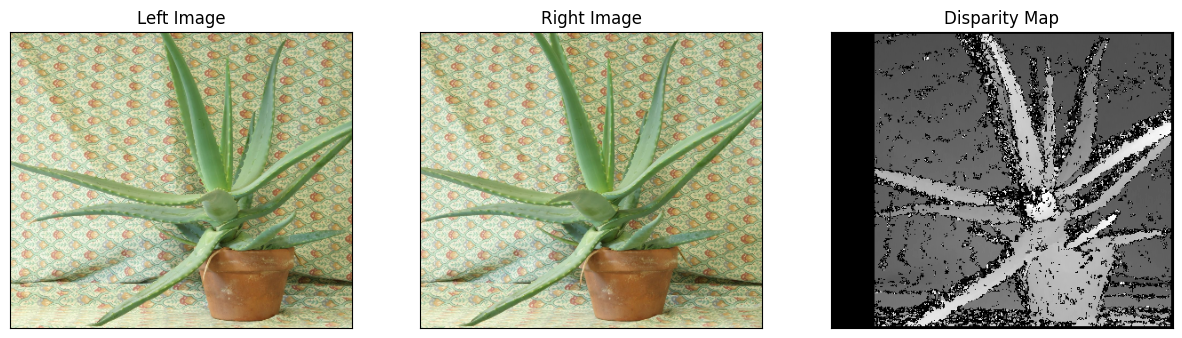

In [10]:
# load left and right images
imgL = cv2.imread(path+"aloeL.jpg")
imgR = cv2.imread(path+"aloeR.jpg")

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# compute disparity map
# numDisparities is multiple of 16
# blocksize is always odd value within 5-255

stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=5) # stereo correspondence using the block matching algorithm
disparity = stereo.compute(imgL_gray, imgR_gray)

# display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(disparity, cmap="gray")
plt.title("Disparity Map"), plt.xticks([]), plt.yticks([])
plt.show()

The horizontal shift between corresponding points in the two images due to their different viewpoints.
$$
Disparity = x_{left} - x_{right}
$$

**Depth Estimation**: Using the disparity map, the depth (Z) of a point in the scene can be computed using the formula:
$$
Z = \frac{f \cdot B}{\text{Disparity}}
$$
where:
- f: Focal length of the camera.
- B: Baseline (distance between the two cameras).

**Applications**:
- Autonomous vehicles: Depth perception for obstacle avoidance.
- Robotics: 3D mapping and navigation.
- 3D Reconstruction: Building 3D models from 2D images.